[Chapter 4] Optimal Clustering

In [ ]:
# a clustering problem consists of a set of objects and a set of features associated with those objects (unsupervised learning)
# the goal is to seperate the objects into groups (called clusters) using the features
#           where intragroup similarities are maximized and intergroup similarities are minimized

# 2 main classes of clustering: partitional (one-level/un-nested) and hierarchical(nested sequence of partitions)
# types of clustering algo: connectivity (e.g. hierarchical clustering), centroids (e.g. k-means), distribution,
#                      density (e.g. DBSCAN, OPTICS), subspace (on 2-dimensions both features and observations, e.g. bi/co-clustering) 

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

import seaborn as sns

base clustering

In [26]:
def clusterKMeansBase(corr0, maxNumClusters=10, n_init=10):
    """
    use k-means algorithm on observation matrix
    """
    # derive observation matrix x as distance matrix
    x = ((1-corr0.fillna(0))/2.)**.5    # corr=1, x=0; corr=-1, x=1
    silh = pd.Series()
    
    for init in range(n_init):  # k-means uses multiple random initialization to avoid local optimas
        for i in range(2, maxNumClusters+1): # loop different number of maxNumClusters
            
            # k-means clustering
            kmeans_ = KMeans(n_clusters=i, n_init=1)  # only initialization once for inner loop
                                                      # n_jobs=1 no need for new version of sklearn
            kmeans_ = kmeans_.fit(x)

            #  calculate silhouette coef in measuring comparing intracluster distance and intercluster distance
            #       Si = (b_i-a_i)/max{a_i, b_i} 
            #       - a_i is the avg distance between i and all other elements in the same cluster
            #       - b_i is the avg distance between i and all the elements in the nearest cluster which i is not a member 
            #       - Si = 1 means i was clustered well and -1 means i was clustered poorly
            silh_ = silhouette_samples(x, kmeans_.labels_)
            
            # clustering quality q = mean(silh)/std(silh)
            # comparing current q_ vs historical optimal q
            stat = (silh_.mean()/silh_.std(), silh.mean()/silh.std())
            if np.isnan(stat[1]) or stat[0]>stat[1]:    
                silh, kmeans=silh_, kmeans_     # select clustering with the highest q

    # reorder correlation matrix based on kmeans clustering
    newIdx = np.argsort(kmeans.labels_)
    corr1 = corr0.iloc[newIdx] # reorder rows
    corr1 = corr1.iloc[:, newIdx] # reorder columns

    # extract/output clustering info
    clstrs = {i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() \
              for i in np.unique(kmeans.labels_)}   # cluster members
    
    silh = pd.Series(silh, index=x.index)
    
    return corr1, clstrs, silh

higher-level clustering

In [28]:
def makeNewOutputs(corr0, clstrs, clstrs2):
    """
    combine two sets of clusters into one unified clustering result.
    update the correlation matrix and silhouette scores accordingly.
    """
    # take two dictionaries of clusters and merge these groups into a single new collection of clusters
    clstrsNew = {}
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs[i])
    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs2[i])
    
    # get new idx of clstrsNew (outer loop i to loop each keys in cltrsNew, inner loop to loop each item for each key) 
    newIdx = [j for i in clstrsNew for j in clstrsNew[i]]
    # extract the relevant subset of the original correlation matrix that corresponds to all items in the new combined clusters
    corrNew = corr0.loc[newIdx, newIdx]
    
    # convert the correlation matrix into distance matrix 
    x = ((1-corr0.fillna(0))/2.)**.5
    # assign cluster labels to each item in this new combined set
    kmeans_labels = np.zeros(len(x.columns))
    for i in clstrsNew.keys():
        idxs = [x.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs] = i
    # calculate silhouette scores, which measure how well each item fits within its cluster.
    silhNew = pd.Series(silhouette_samples(x, kmeans_labels), index=x.index)
    # returns the updated correlation matrix, combined clusters, and silhouette scores
    return corrNew, clstrsNew, silhNew

#---------------------------------------------------------------------------------

def clusterKMeansTop(corr0, maxNumClusters=None, n_init=10):
    """
    perform K-means clustering on the correlation matrix.
    identify weak clusters based on silhouette scores.
    recursively refine those weak clusters by re-clustering them.
    decide whether the refinement improves clustering quality or not.
    """
    # intial clustering
    # run base K-means clustering on full dataset and get initial clusters and silh scores
    if maxNumClusters==None: maxNumClusters=corr0.shape[1]-1
    corr1, clstrs, silh=clusterKMeansBase(corr0, maxNumClusters=\
        min(maxNumClusters, corr0.shape[1]-1), n_init=n_init)
    
    # evaluate clusters
    # calculate qualtiy(t-stat like) score for each cluster
    clusterTstats = {i:np.mean(silh[clstrs[i]]) / \
        np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    # compute the average quality across all clusters
    tStatMean = sum(clusterTstats.values())/len(clusterTstats)
    
    # identify weak clusters
    # find the set of weak clusters with quality below average
    redoClusters = [i for i in clusterTstats.keys() if \
        clusterTstats[i]<tStatMean]
    # refine the weak clusters (redoClusters)
    if len(redoClusters)<=1:
        return corr1, clstrs, silh
    else:
        # if multiple weak clusters
        # extract items in those weak clusters
        keysRedo = [j for i in redoClusters for j in clstrs[i]]
        corrTmp = corr0.loc[keysRedo, keysRedo]
        tStatMean = np.mean([clusterTstats[i] for i in redoClusters])
        # run the clustering function recursively on just those items, aiming to split or reorganize them into better clusters.
        corr2, clstrs2, silh2 = clusterKMeansTop(corrTmp, \
            maxNumClusters=min(maxNumClusters, corrTmp.shape[1]-1), n_init=n_init)
        # make new outputs
        # merge the strong clusters (clstrs no in redoClusters) with the refined weak clusters (clstrs2)
        corrNew, clstrsNew, silhNew = makeNewOutputs(corr0, \
            {i: clstrs[i] for i in clstrs.keys() if i not in redoClusters}, clstrs2)
        # recalculate the evaluation metrics on this updated combined clustering
        newTstatsMean = np.mean([np.mean(silhNew[clstrsNew[i]])/ \
            np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()])
        # return the best clustering (either original or refined) 
        if newTstatsMean <= tStatMean:
            return corr1, clstrs, silh   # otherwise, keep the original clustering
        else:
            return corrNew, clstrsNew, silhNew # if the new combined clustering is better, return the new ones

experimental results

100
0.6779997866536374
0.00495905524173486 0.0013345847388943357
0.003455970753593775 0.0015111792343800799


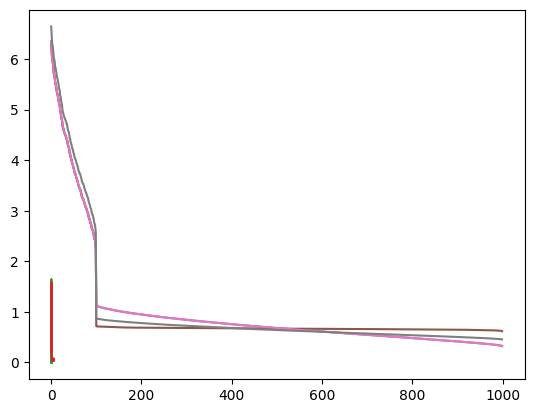

In [13]:
# design monte carlo experiment to verify the accuracy of Optimal-Number-of-Clusters (ONC) algo 
# 1. create generate random block correlation matrix (N, M, K) (of size NxN, made up of K blocks, each of size >=M)
#    where intrablock corr is high and across-block corr is low
# 2. shuffle that corr matrix
# 3. apply ONC and verify that ONC algo recovers the block we injected

from scipy.linalg import block_diag
from sklearn.utils import check_random_state

import import_ipynb
from ch2 import cov2corr

generation of random block-structured correlation matrix

In [15]:
# random block correlation matrix
def getCovSub(nObs, nCols, sigma, random_state=None):
    """
    generate a random covariance (or correlation) matrix for a single block of variables
    - nObs: number of observations (samples) to simulate.
    - nCols: number of variables (columns) in this block.
    - sigma: noise level controlling variability
    - random_state: seed or random generator for reproducibility.
    """
    # create a random number generator (rng) for consistent random results
    rng = check_random_state(random_state)

    # if the block has only 1 variable, return 1x1 cov matrix
    if nCols==1:
        return np.ones((1,1))
    
    # generate a single column vector of nObs samples from a standard normal distribution
    ar0 = rng.normal(size=(nObs, 1))
    
    # repeat this single column horizontally nCols times, creating a matrix where all columns are initially identical
    ar0 = np.repeat(ar0, nCols, axis=1)

    # add Gaussian noise with standard deviation sigma independently to each element, making columns similar but not identical
    # the columns will be highly correlated for smaller sigma, less correlated for larger signma
    ar0 += rng.normal(scale=sigma, size=ar0.shape)
    # compute the covariance matrix of the simulated data (ar0), treating columns as variables (rowvar=False)
    ar0 = np.cov(ar0, rowvar=False)

    # return covariace matrix
    return ar0

#----------------------------------------------------------------

def getRndBlockCov(nCols, nBlocks, minBlockSize=1, sigma=1., random_state=None):
    """
    generate a block diagonal covariance matrix composed of nBlocks blocks, each block generated by getCovSub
    - nCols: Total number of variables across all blocks.
    - nBlocks: Number of blocks to create.
    - minBlockSize: Minimum size of each block.
    - sigma: Noise parameter passed to getCovSub.
    - random_state: Random seed or generator.
    """
    # random number generator
    rng = check_random_state(random_state)
    
    # randomly choose nBlocks-1 split points within the range of variables to divide the total variables into blocks
    # set B = first, randomly choose K-1 distinct items from set A = (1, ..., N'-1) 
    # N' = N - K(M-1) >=K (given N>=KM) 
    parts = rng.choice(range(1, nCols-(minBlockSize-1)*nBlocks), \
        nBlocks-1, replace=False)
    # ascending order
    parts.sort()
    # append N' to B (parts of size K) as the last split point
    parts = np.append(parts, nCols-(minBlockSize-1)*nBlocks)

    # calculate the size of each block
    # parts = [i1, i2] => parts = [i1, i2-i1] given C1=0,...,i1-1, C2=i1,...,i2-1
    # -1 + minBlockSize to adjust the size and ensure it will be no less than minimum block size
    parts = np.append(parts[0], np.diff(parts)) - 1 + minBlockSize

    cov = None # initialize cov
    # for each block size (nCols_) in parts:
    # generate a covariance matrix for each block using getCovSub.
    # stack it along the diagonal of a larger block diagonal matrix
    for nCols_ in parts:
        # calculate covariance matrix of each block using getCovSub
        #   nObs is no less than nCols_*(nCols_+1)/2. given degree of freedom of cov (nCols__*nCols_/2 + nCols_) and statistical robustness
        cov_ = getCovSub(int(max(nCols_*(nCols_+1)/2., 100)), 
            nCols_, sigma, random_state=rng)
        if cov is None: # If this is the first block, initialize cov with it.
            cov = cov_.copy()         
        else:   # Otherwise, append the new block covariance matrix as a block diagonal to the existing cov
            cov = block_diag(cov, cov_) 
    return cov

#----------------------------------------------------------------

def randomBlockCorr(nCols, nBlocks, random_state=None, minBlockSize=1):
    """
    generate a random block-structured correlation matrix
    """
    rng = check_random_state(random_state)

    # generate a block covariance matrix with moderate noise (sigma=0.5).
    cov0 = getRndBlockCov(nCols, nBlocks, minBlockSize, sigma=0.5, random_state=rng)

    # generate a single block covariance matrix for all variables with higher noise (sigma=1), acting as noise added to the entire matrix.
    cov1 = getRndBlockCov(nCols, 1, minBlockSize, sigma=1., random_state=rng)

    # add the noise matrix to the block covariance matrix to introduce variability across blocks
    cov0 += cov1

    # convert to correlation matrix
    corr0 = cov2corr(cov0)
    corr0 = pd.DataFrame(corr0)

    return corr0

<Axes: >

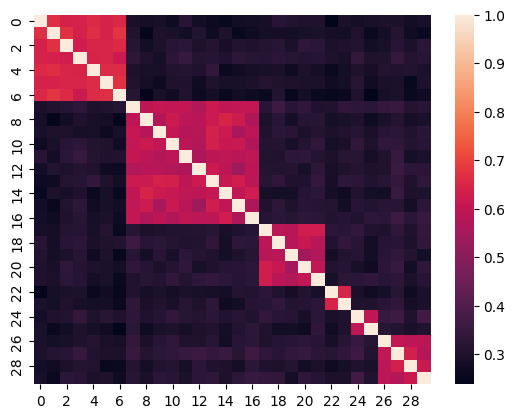

In [33]:
# generate a block-structured correlation matrix before shuffling (of 30 variables, 6 blocks, seed=123, minblocksize=2)
corr_matrix = randomBlockCorr(30, 6, 123, 2)
sns.heatmap(corr_matrix)
# light color indicate a higher correalation 
# dark color indicate a lower correlation

<Axes: >

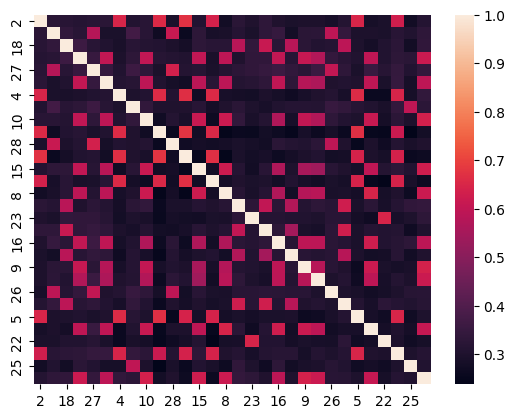

In [36]:
# shuffle the rows and columns of the generated block-structured matrix

def shuffle_corr_matrix(corr, seed=123):
    rng = np.random.default_rng(seed=seed)  # for reproducibility
    indices = np.array(corr.index)
    shuffled_indices = rng.permutation(indices)
    corr_shuffled = corr.loc[shuffled_indices, shuffled_indices]
    return corr_shuffled, shuffled_indices

corr_shuffled, shuffled_indices = shuffle_corr_matrix(corr_matrix)

sns.heatmap(corr_shuffled)

C:\Users\user\AppData\Local\Temp\ipykernel_22496\1279668690.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  silh = pd.Series()
C:\Users\user\AppData\Local\Temp\ipykernel_22496\1279668690.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  silh = pd.Series()
C:\Users\user\AppData\Local\Temp\ipykernel_22496\1279668690.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  silh = pd.Series()


<Axes: >

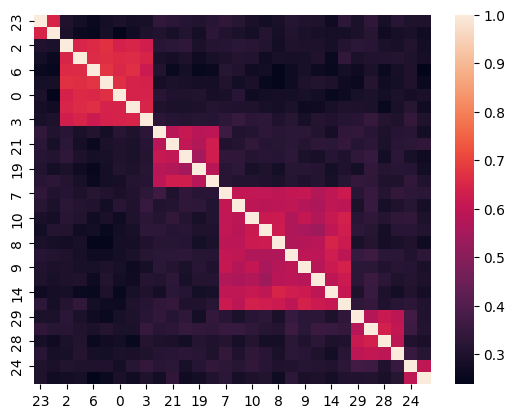

In [37]:
# recover the shuffled matrix using ONC algo and validate the result with actual matrix
corr_recovered, clusters_recovered, silh_recovered = clusterKMeansTop(
    corr_shuffled, maxNumClusters=10, n_init=10
)

sns.heatmap(corr_recovered)
# estimated K = 6 = actual K